In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import os
import time

In [0]:
tf.enable_eager_execution()

In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 120
EPOCHS = 200
seed_z = tf.random.normal([10, 62])
code_cont = tf.random.normal([10, 2])
code_disc = np.arange(0, 10).reshape(-1, 1)
code_disc = tf.one_hot(code_disc,depth=10)
code_disc = tf.reshape(code_disc,(10,10))
codes = tf.concat((code_disc, code_cont), axis=1)

In [0]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape(-1, 28,28, 1)
train_images = train_images.astype(np.float32)
train_images = (train_images - 127.5) / 127.5
train_labels= tf.one_hot(train_labels,depth=10)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [0]:
class Discriminator(keras.Model):
    def __init__(self):
        super().__init__(name = "discriminator")
        self.conv1 = keras.layers.Conv2D(filters=128,kernel_size=(4,4),strides=2,padding='same',kernel_initializer=keras.initializers.random_normal(mean=0.0, stddev=0.02))
        self.leaky_1 = keras.layers.LeakyReLU(alpha = 0.2)
        self.conv2 = keras.layers.Conv2D(filters=256,kernel_size=(4,4),strides=2,padding='same')
        self.BN1 = keras.layers.BatchNormalization()
        self.leaky_2 = keras.layers.LeakyReLU(alpha = 0.2)
        self.flatten = keras.layers.Flatten()
        self.Dense = keras.layers.Dense(units = 1024)
        self.BN2 = keras.layers.BatchNormalization()
        self.leaky_3 = keras.layers.LeakyReLU(alpha = 0.2)
        self.output_D = keras.layers.Dense(units = 1, activation='sigmoid')
        
        self.Dense_Q = keras.layers.Dense(units = 128)
        self.BN_Q = keras.layers.BatchNormalization()
        self.leaky_Q = keras.layers.LeakyReLU(alpha = 0.2)
        self.output_Q = keras.layers.Dense(units = 10, activation='softmax')
        
    def call(self, input_tensor):
        x = self.conv1(input_tensor)
        x = self.leaky_1(x)
        x = self.conv2(x)
        x = self.BN1(x)
        x = self.leaky_2(x)
        x = self.flatten(x)
        x = self.Dense(x)
        x = self.BN2(x)
        x = self.leaky_3(x)
        d = self.output_D(x)

        q = self.Dense_Q(x)
        q = self.BN_Q(q)
        q = self.leaky_Q(q)
        q = self.output_Q(q)
        return d, q


discriminator = Discriminator()

In [0]:
class Generator(keras.Model):
    
    def __init__(self):
        super().__init__(name='generator')
        self.input_layer = keras.layers.Dense(1024)
        self.BN1 = keras.layers.BatchNormalization()
        self.relu1 = keras.layers.ReLU()
        self.Dense1 = keras.layers.Dense(7*7*128)
        self.reshape = keras.layers.Reshape((7,7,128))
        self.BN2 = keras.layers.BatchNormalization()
        self.relu2 = keras.layers.ReLU()
        self.conv2dT1 = keras.layers.Conv2DTranspose(filters=64,kernel_size=(4,4),padding='same',strides=2,kernel_initializer=keras.initializers.random_normal(mean=0.0, stddev=0.02))
        self.BN3 = keras.layers.BatchNormalization()
        self.relu3 = keras.layers.ReLU()
        self.output_layer = keras.layers.Conv2DTranspose(filters=1,kernel_size=(4,4),strides=2,padding='same',activation = "tanh")
       
    def call(self, input_tensor):
        x = self.input_layer(input_tensor)
        x = self.BN1(x)
        x = self.relu1(x)
        x = self.Dense1(x)
        x = self.reshape(x)
        x = self.BN2(x)
        x = self.relu2(x)
        x = self.conv2dT1(x)
        x = self.BN3(x)
        x = self.relu3(x)
        x = self.output_layer(x)
      
        return x
    
    def generate_noise(self,batch_size, random_noise_size):
        noise = tf.random.normal([batch_size, random_noise_size])
        return noise

generator = Generator()

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def Discriminator_loss(real_output, fake_output,smoothing_factor = 0.9):
        real_loss = cross_entropy(tf.ones_like(real_output)*smoothing_factor, real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

def Generator_loss(fake_output):
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss

def Q_loss(q,c):
    cond_entropy = tf.reduce_mean(-tf.reduce_sum(tf.log(q) + 1e-8) * c, 1)
    lat_entropy = tf.reduce_mean(-tf.reduce_sum(tf.log(c + 1e-8) * c, 1))
    total_entropy = tf.cast(cond_entropy, tf.float32) + tf.cast(lat_entropy, tf.float32)
    return total_entropy

In [0]:
discriminator_optimizer = keras.optimizers.Adam(0.0002,0.5)
generator_optimizer = keras.optimizers.Adam(0.0002,0.5)
Q_optimizer = keras.optimizers.Adam(0.0002,0.5)

In [0]:
def conv_cond_concat(x, y):
    x_shapes = tf.shape(x)
    y_shapes = tf.shape(y)
    y = tf.reshape(y, [-1, 1, 1, y_shapes[1]])
    y_shapes = tf.shape(y)
    return tf.concat([x, y*tf.ones([x_shapes[0], x_shapes[1], x_shapes[2], y_shapes[3]])], 3)

In [0]:
@tf.function()
def training(generator: Generator, discriminator: Discriminator, images:np.ndarray, labels:np.ndarray , k:int =1, batch_size = BATCH_SIZE):
    noise = generator.generate_noise(batch_size, 62)
    code_cont = tf.random.normal([batch_size, 2])
    batch_codes = tf.concat((labels, code_cont), axis=1)
    batch_z_c = tf.concat([noise, batch_codes], 1)
    real_images = conv_cond_concat(images, batch_codes)
    for _ in range(k):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape, tf.GradientTape() as Q_tape:
            generated_images = generator(batch_z_c,training=True)
            generated_images = conv_cond_concat(generated_images, batch_codes)
            real_output, _ = discriminator(real_images,training=True)
            fake_output, q = discriminator(generated_images,training=True)

            gen_loss = Generator_loss(fake_output)
            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

            disc_loss = Discriminator_loss(real_output, fake_output)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

            q_loss = Q_loss(q,batch_codes)
            gradients_of_q = Q_tape.gradient(q_loss, discriminator.trainable_variables)
            Q_optimizer.apply_gradients(zip(gradients_of_q, discriminator.trainable_variables))


In [0]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input,training=False)
    #predictions=tf.image.resize_images(predictions, [28, 28])

    plt.figure(figsize=(10,10))

    for i in range(predictions.shape[0]):
        plt.subplot(1, 10, i+1) 
        plt.imshow(tf.reshape(predictions[i], shape = (28,28)), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [0]:
def train(dataset, epochs):
    for epoch in range(epochs+1):
        start = time.time()
        for image_batch, labels_batch in dataset:
            training(generator, discriminator, image_batch,labels_batch ,k = 1, batch_size=BATCH_SIZE)
        if (epoch % 10) == 0:
            print('Epoch:', str(epoch))
            print ('Time for epoch {} is {} sec'.format(epoch, time.time()-start))

            seed_concat=tf.concat([seed_z,codes],1)
            generate_and_save_images(generator,epoch,seed_concat)

Epoch: 0
Time for epoch 0 is 16.056646823883057 sec


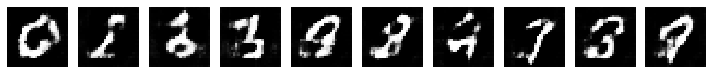

Epoch: 10
Time for epoch 10 is 13.389461278915405 sec


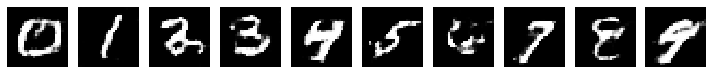

Epoch: 20
Time for epoch 20 is 13.397644758224487 sec


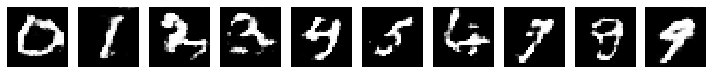

Epoch: 30
Time for epoch 30 is 13.392038822174072 sec


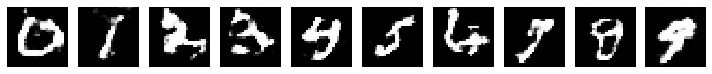

Epoch: 40
Time for epoch 40 is 13.399407148361206 sec


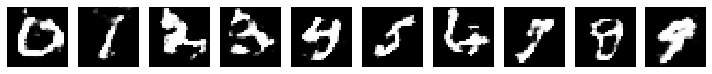

Epoch: 50
Time for epoch 50 is 13.388677835464478 sec


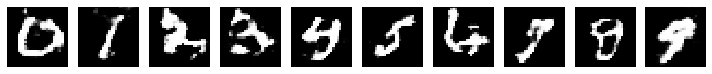

Epoch: 60
Time for epoch 60 is 13.396775245666504 sec


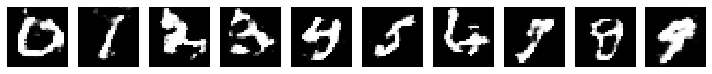

Epoch: 70
Time for epoch 70 is 13.384305715560913 sec


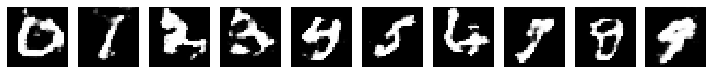

Epoch: 80
Time for epoch 80 is 13.390858888626099 sec


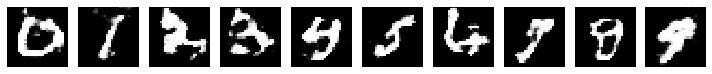

Epoch: 90
Time for epoch 90 is 13.386906385421753 sec


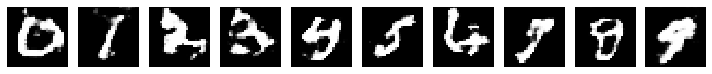

Epoch: 100
Time for epoch 100 is 13.383287906646729 sec


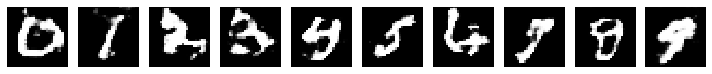

Epoch: 110
Time for epoch 110 is 13.37019419670105 sec


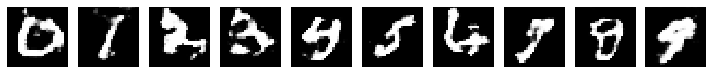

Epoch: 120
Time for epoch 120 is 13.391525268554688 sec


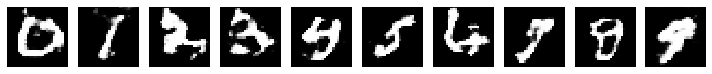

Epoch: 130
Time for epoch 130 is 13.38530707359314 sec


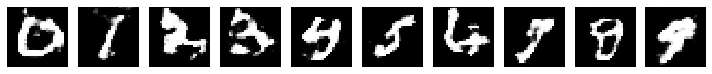

Epoch: 140
Time for epoch 140 is 13.400693655014038 sec


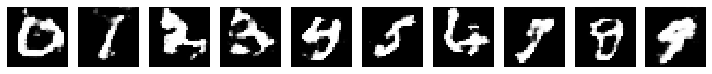

Epoch: 150
Time for epoch 150 is 13.406975269317627 sec


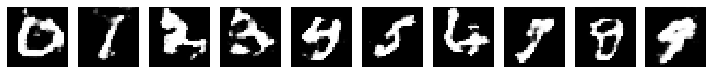

Epoch: 160
Time for epoch 160 is 13.40154218673706 sec


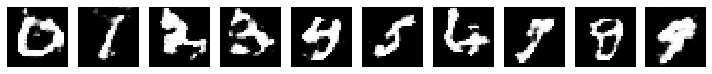

Epoch: 170
Time for epoch 170 is 13.391948699951172 sec


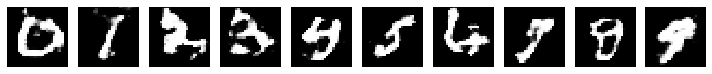

Epoch: 180
Time for epoch 180 is 13.394216775894165 sec


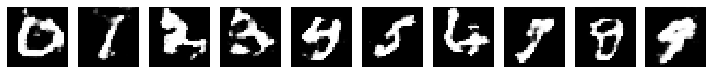

Epoch: 190
Time for epoch 190 is 13.39910364151001 sec


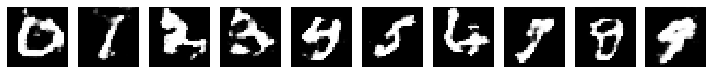

Epoch: 200
Time for epoch 200 is 13.393116474151611 sec


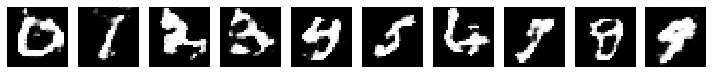

CPU times: user 14min 8s, sys: 1min 34s, total: 15min 43s
Wall time: 45min 1s


In [143]:
%%time
train(train_dataset, EPOCHS)